In [1]:
import osmnx as ox
import pandas as pd
import plotly.express as px
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
address = 'Denver County, CO'
#This might require a for loop of the following counties
#Boulder, Broomfield, Denver and Jefferson counties, parts of Adams, Arapahoe and Douglas Counties, and a small portion of Weld County

In [3]:
osm_bridges = ox.geometries_from_address(address, tags = {'bridge': True}, dist=72000) #dist should be 72000
#remove not automotive bridges
osm_bridges= osm_bridges.loc[osm_bridges['highway'] != 'footway']
osm_bridges= osm_bridges.loc[osm_bridges['highway'] != 'steps']
osm_bridges= osm_bridges.loc[osm_bridges['highway'] != 'cycle way']
osm_bridges= osm_bridges.loc[osm_bridges['highway'] != 'path']
osm_bridges= osm_bridges.loc[osm_bridges['highway'] != 'cycleway']

In [4]:
#Use this to check which bridges were captured by OSM
print(osm_bridges)

                                                                    nodes  \
element_type osmid                                                          
way          42120252                              [523576743, 523576736]   
             42120253                              [523576747, 523576749]   
             82803807                              [177269174, 177269176]   
             99372506                [1149365411, 1149365919, 1149365904]   
             99372516    [1083003443, 8947636062, 1624757014, 1083003451]   
...                                                                   ...   
             979355358                           [9060563307, 9060563308]   
             979355360               [9060563310, 9806780781, 9060563309]   
             1080084337                          [9900237022, 9900237023]   
             1124319400                        [10281497564, 10281497563]   
             1198173930                        [11115457982, 11115457981]   

In [5]:
osm_bridges['geometry'] = osm_bridges.buffer(.0002)

C:\Users\Matucoco\AppData\Local\Temp\ipykernel_9552\4070958601.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  osm_bridges['geometry'] = osm_bridges.buffer(.0002)


<Axes: >

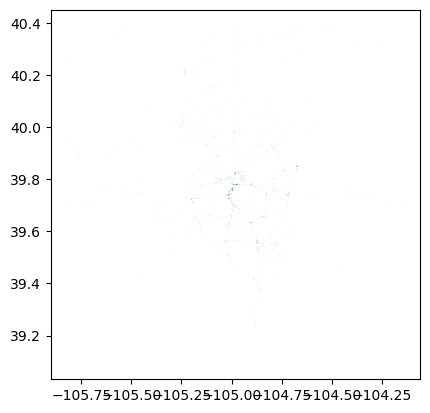

In [6]:
osm_bridges.plot()

In [7]:
file_name='shape_routes_elevation'

In [8]:
#bring in bus routes with bad USGS elevation data
bus_routes= gpd.read_file(f'{file_name}.zip')
#bus_routes.head()

In [9]:
#Check the crs of the bus and bridge data

bus_routes = bus_routes.to_crs("EPSG:4326")
print(osm_bridges.crs)
print(bus_routes.crs)

epsg:4326
EPSG:4326


In [10]:
#bus_routes = bus_routes.rename(columns={"geometry": "geometry_route"})
bus_routes.head()


,cat,cat_,shape_id,begin,end,shapes_joi,shapes_j_1,length,z_start,z_end,slope,geometry
0,1,1,1252641,1,1078,DASH,1,152.306,1585.819,1586.263,0.003,"LINESTRING Z (-105.08973 39.98859 1585.81934, ..."
1,2,1,1252641,1,1078,DASH,1,152.306,1586.263,1586.207,-0.000,"LINESTRING Z (-105.09053 39.98777 1586.26257, ..."
2,3,1,1252641,1,1078,DASH,1,152.306,1586.207,1587.204,0.007,"LINESTRING Z (-105.09128 39.98698 1586.20740, ..."
3,4,1,1252641,1,1078,DASH,1,152.306,1587.204,1588.533,0.009,"LINESTRING Z (-105.09306 39.98699 1587.20410, ..."
4,5,1,1252641,1,1078,DASH,1,152.306,1588.533,1590.076,0.010,"LINESTRING Z (-105.09485 39.98700 1588.53345, ..."


In [11]:
#mark bus route segements that cross a bridge
bus_routes['bridge_check']=bus_routes.within(osm_bridges.unary_union) 

In [12]:
print(bus_routes.groupby('bridge_check').size()) #check that the bus routes are marked properly

bridge_check
False    71946
True       800
dtype: int64


In [13]:
bus_routes.head()

,cat,cat_,shape_id,begin,end,shapes_joi,shapes_j_1,length,z_start,z_end,slope,geometry,bridge_check
0,1,1,1252641,1,1078,DASH,1,152.306,1585.819,1586.263,0.003,"LINESTRING Z (-105.08973 39.98859 1585.81934, ...",False
1,2,1,1252641,1,1078,DASH,1,152.306,1586.263,1586.207,-0.000,"LINESTRING Z (-105.09053 39.98777 1586.26257, ...",False
2,3,1,1252641,1,1078,DASH,1,152.306,1586.207,1587.204,0.007,"LINESTRING Z (-105.09128 39.98698 1586.20740, ...",False
3,4,1,1252641,1,1078,DASH,1,152.306,1587.204,1588.533,0.009,"LINESTRING Z (-105.09306 39.98699 1587.20410, ...",False
4,5,1,1252641,1,1078,DASH,1,152.306,1588.533,1590.076,0.010,"LINESTRING Z (-105.09485 39.98700 1588.53345, ...",False


In [14]:
#Create a new columns that sets slope to zero if a bridge is crossed
bus_routes['slope_bridgeless'] = bus_routes['slope']
bus_routes.loc[bus_routes['bridge_check'] == True, 'slope_bridgeless'] = 0


In [15]:
#Check that slopes were set to zero
bus_routes.loc[bus_routes['bridge_check'] == True].head()

,cat,cat_,shape_id,begin,end,shapes_joi,shapes_j_1,length,z_start,z_end,slope,geometry,bridge_check,slope_bridgeless
264,265,3,1252105,1,868,16,0,150.945,1585.735,1584.103,-0.011,"LINESTRING Z (-105.02125 39.74045 1585.73462, ...",True,0.0
265,266,3,1252105,1,868,16,0,150.945,1584.103,1582.896,-0.008,"LINESTRING Z (-105.01949 39.74044 1584.10315, ...",True,0.0
266,267,3,1252105,1,868,16,0,150.945,1582.896,1585.105,0.015,"LINESTRING Z (-105.01774 39.74040 1582.89612, ...",True,0.0
267,268,3,1252105,1,868,16,0,150.945,1585.105,1583.795,-0.009,"LINESTRING Z (-105.01598 39.74036 1585.10498, ...",True,0.0
268,269,3,1252105,1,868,16,0,150.945,1583.795,1583.044,-0.005,"LINESTRING Z (-105.01422 39.74033 1583.79468, ...",True,0.0


In [16]:
#save to shapefile
bus_routes.to_file(f'{file_name}_bridge_fix.shp.zip', driver='ESRI Shapefile')

C:\Users\Matucoco\AppData\Local\Temp\ipykernel_9552\1328132533.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bus_routes.to_file(f'{file_name}_bridge_fix.shp.zip', driver='ESRI Shapefile')


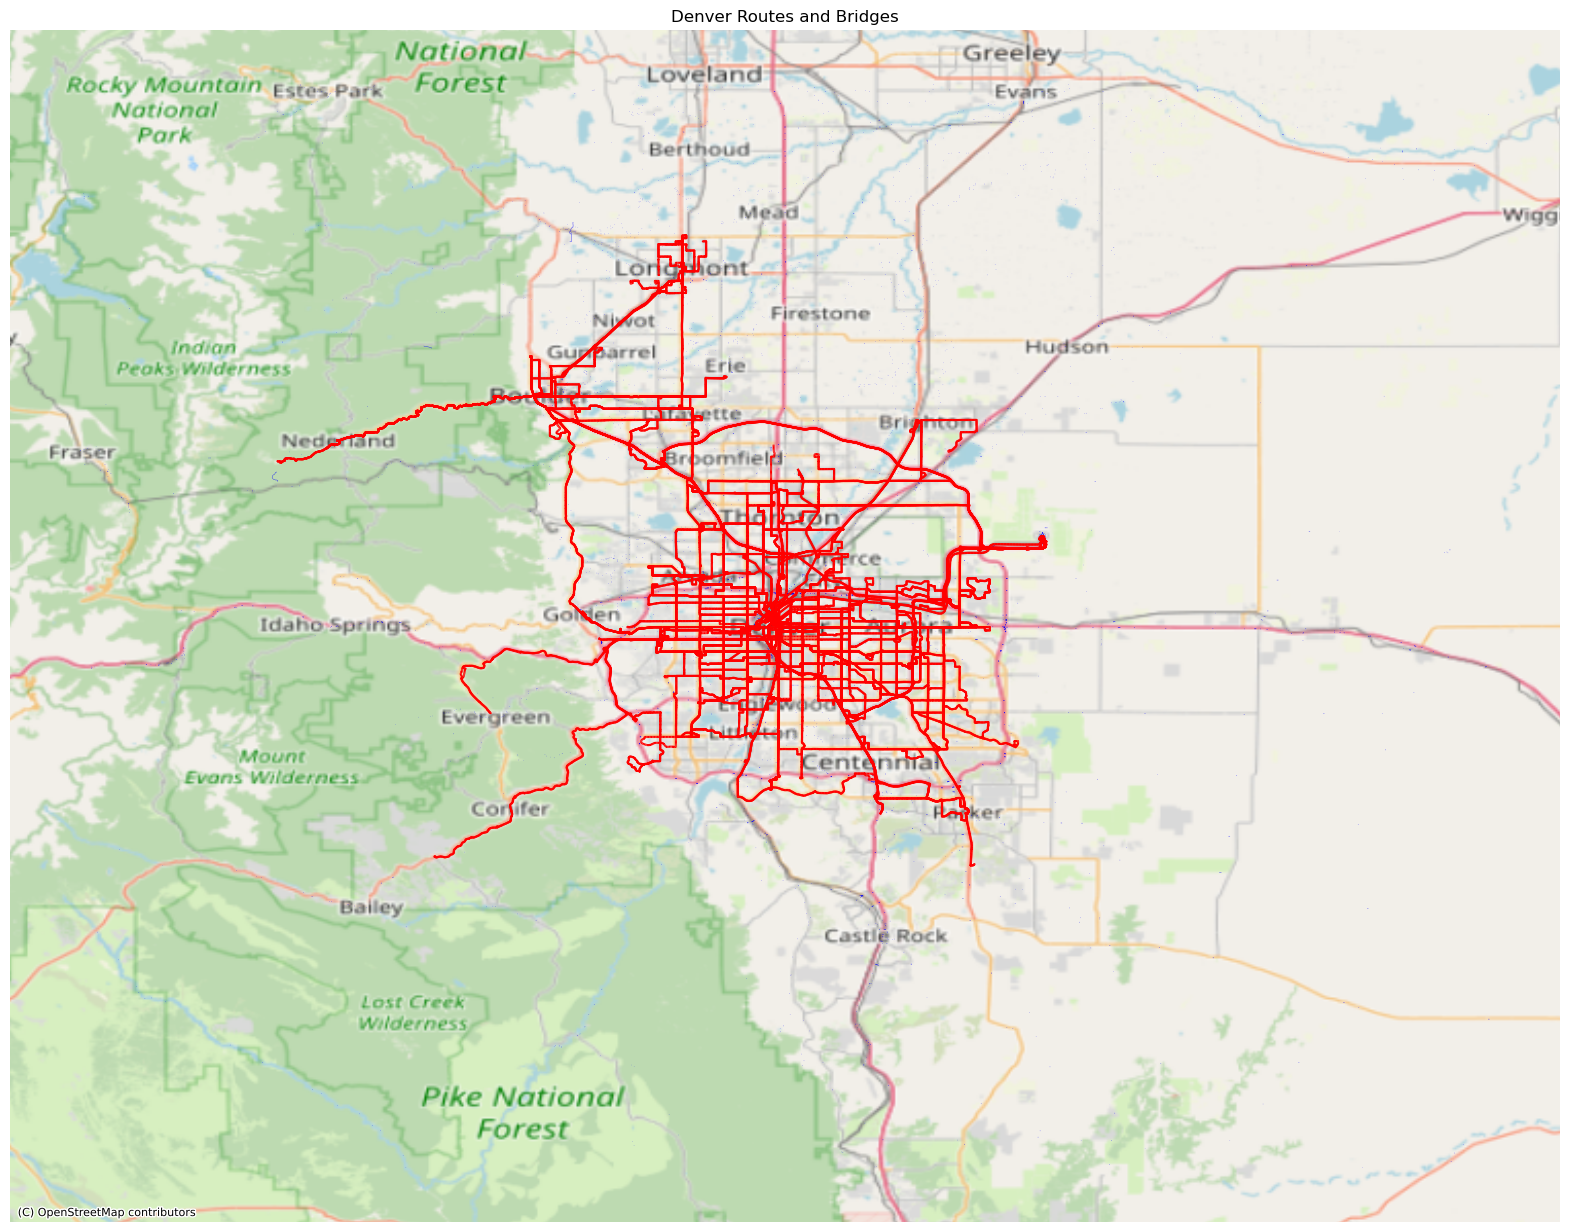

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
osm_bridges.plot(ax=ax, color = 'blue')
bus_routes.plot(ax=ax, color = 'red')
ax.set_axis_off()
ctx.add_basemap(ax,
               crs=osm_bridges.crs.to_string(),
               source=ctx.providers.OpenStreetMap.Mapnik
              )
ax.set_title(f"Denver Routes and Bridges")
plt.draw()

In [18]:
bus_routes.to_csv(f'{file_name}_bridge_fix.csv')